In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from athena import Athena
import matplotlib.pyplot as plt

# How to Run Simulations with Athena

### First Step: Initialize Simulation Parameters

Athena enables you to simulate Single Cell CRISPR Screens. Before you can run simulations you need to provide Athena with simulation parameters most noteably: on target activity, off target activity, type of CRISPR pertubation, number of Transcription Factors (TFs), number of E-genes, number of kinases, and the number of signalling cascades you want to simulate. Additional parameters you can provide include the number of cells per condition to simulate to where directory to store simulation data.

It's important to note that when initializing the Athena class is when you pass the parameters to Athena. All methods afterwards do not require or do not take any parameters.

In [2]:
athena = Athena(on_target=0.0, 
                off_target=0, 
                negenes=200,
                nkinases=15,
                ncascades=3, 
                ncpus=3, nbatches=4,
                ngrnas_per_target=1,
                crispr_type='Knockout',
                ncells_per_condition=1000)

Initiate Environmental Parameters...
Check the caches...
Setup Simulator Directory...
Check Network Parameters...
Check gRNA Parameters...
Check Simulation Parameters...
Check Downsampling Parameters...


### Second Step: Create Gene Regulatory Network and Signalling Cascade

Both Gene Regulator Networks and Signalling Cascades are created using Modular Sampling method originally developed by GeneNetWeaver. This modular sampling method allows us to capture the scale-free and modular nature of biologically networks in comparison to an other scale-free random sampling method. Thereby allowing us to better represent the flow between reactions that occurs in biological networks.

**No parameters are required** 

In [3]:
athena.create_network()

Created Network...


### Third Step:  Initialize Reaction Kinectics

Next we need to initialize reaction kinetics of both our GRN and Signalling Cascade.

**No parameters are required**

In [4]:
athena.initialize_kinetics()

Initialized Kinetics...


### Fourth Step: Create Guide RNA Metadata

Creating gRNA Metadata and Perturbation Coefficient Matrix.

**No parameters are required**

In [5]:
athena.generate_grnas()

100%|██████████| 26/26 [00:00<00:00, 52053.41it/s]


### Fifth Step:  Compile Reactions for Simulation

Once we have initialized the kinetics and create gRNA metadata we need to convert all of this information in complied affinity and propensity probability calculation. This is required for the novel GPU Based Gillespie Algorithm.

**No parameters are required**

In [6]:
athena.compiling()

Starting to Processing Batch 0...
Starting to Processing Batch 1...
Starting to Processing Batch 2...
Finished Processing Batch 0...
Starting to Processing Batch 3...
Finished Processing Batch 2...
Starting to Processing Batch 4...
Finished Processing Batch 1...
Finished Processing Batch 3...
Finished Processing Batch 4...


### Sixith Step: Run Gillispie Tau Leaping Algorithm

Now that we have compiled the chemical reactions we can run our simulations. Athena uses a opencl implementation of the Gillespie Tau-Leaping Algorithm. Which means Athena is CPU and GPU compatible. However, for obvious reasons using a GPU dramatically increases the speed of any simulation you want to run.

**No parameters are required**

In [7]:
athena.run()

Batch 0 Started...
Creating Command Queue...
Start Simulation...


100%|██████████| 6000/6000 [01:37<00:00, 61.24it/s]


Simulation Complete. Processing Results...
Batch 0 Completed...
Batch 1 Started...
Creating Command Queue...
Start Simulation...


100%|██████████| 6000/6000 [01:26<00:00, 69.14it/s]


Simulation Complete. Processing Results...
Batch 1 Completed...
Batch 2 Started...
Creating Command Queue...
Start Simulation...


100%|██████████| 6000/6000 [01:26<00:00, 69.09it/s]


Simulation Complete. Processing Results...
Batch 2 Completed...
Batch 3 Started...
Creating Command Queue...
Start Simulation...


100%|██████████| 6000/6000 [01:26<00:00, 69.09it/s]


Simulation Complete. Processing Results...
Batch 3 Completed...
Batch 4 Started...
Creating Command Queue...
Start Simulation...


100%|██████████| 6000/6000 [01:35<00:00, 62.65it/s]


Simulation Complete. Processing Results...
Batch 4 Completed...


### Seventh Step: Sample Cells and Downsample Counts

Now that we have simulated cells we can randomly sample our cells and downsample our cells mRNA counts. Athena downsamples simulated cells mRNA counts using the a reference single cell dataset to parameterize both the number of mRNAs the cell will have (also known as a cells library size) and probability that a given mRNA of a given gene is sampled. 

**Parameters Avaliable**

- ncells: number of cells you want to sample from simulated cells
- pop_fp: file path to a loom file that is scanpy compatible that contains single cell dataset. If provided will use the provided dataset to downsample counts instead of internal single cell populations.

In [8]:
cells_meta, gene_expr = athena.sample(ncells=1000)

Sampling Cells...


51000it [00:19, 2604.70it/s]


Sampling Molecules...


26000it [00:01, 16820.32it/s]


Caching....


### Demonstrating that Gene Expression Equals Library Size

The total number of UMIs are samples from real single cell datasets. Once we sampled a cells library size we then downsample mRNA molecules of simulated cells.

In [9]:
cells_meta['mat_count_sums'] = gene_expr.sum(axis=1)

In [10]:
cells_meta[['lib_size', 'mat_count_sums']]

lib_size  mat_count_sums
0        3996.0          3996.0
1        4852.0          4852.0
2        3996.0          3996.0
3        3885.0          3885.0
4        3922.0          3922.0
...         ...             ...
25995    4062.0          4062.0
25996    3984.0          3984.0
25997    3996.0          3996.0
25998    3945.0          3945.0
25999    3582.0          3582.0

[26000 rows x 2 columns]

# Visualizing Gene Expression of Gillespie SSA

Now that we conducted a simulation let's see the effects our perturbations have upon our target genes. As we can see when using a Knockout CRISPR type all perturbed cells have count of zero for our target gene. In addition, these perturbations dramatically alter the expression level of multiple genes demonstrating that our simulated cells have been perturbed.

In [26]:
athena.sim_meta['sim_index'] = 1 + athena.sim_meta.index.values * 10
sim_meta = athena.sim_meta.loc[athena.sim_meta.sample_percent != 0]

In [27]:
grna_meta = athena.grna_meta.merge(sim_meta[['grna', 'sim_index']], on='grna')
genes_to_plot = ["mol_mrna_" + gene for gene in grna_meta.perturbed_gene.values if gene != 'CTRL']

grna_meta['sim_index'] = np.nan
grna_sims = cells_meta[['sim_i', 'grna']].drop_duplicates()
grna_sims = grna_sims.sort_values(by=['sim_i', 'grna'])
grna_sims = grna_sims.reset_index(drop=True)

for grna in grna_meta.grna.values:
    grna_meta.loc[grna_meta.grna == grna, 'sim_index'] = grna_sims.loc[grna_sims.grna == grna, 'sim_i'].values[0]

simulations = pd.read_csv(f'{athena.results_dir}/simulated_counts.csv')

In [28]:
df = {"mol_counts": [], "mol": [], "time_step": [], "sim_index": [], "perturbed_gene": []}

for index, row in grna_meta.iterrows():
    for gene in genes_to_plot:
        sim = simulations.loc[simulations.sim_i == row.sim_index, gene]
        sim = sim.reset_index(drop=True)
        
        df['time_step'] = df['time_step'] + list(sim.index)
        df['mol_counts'] = df['mol_counts'] + list(sim.values)
        df['mol'] = df['mol'] + [gene] * len(list(sim.values))
        df['sim_index'] = df['sim_index'] + [row.sim_index] * len(list(sim.values))
        df['perturbed_gene'] = df['perturbed_gene'] + [row.perturbed_gene] * len(list(sim.values))
    
df = pd.DataFrame(df)

  0%|          | 0/26 [00:00<?, ?it/s]

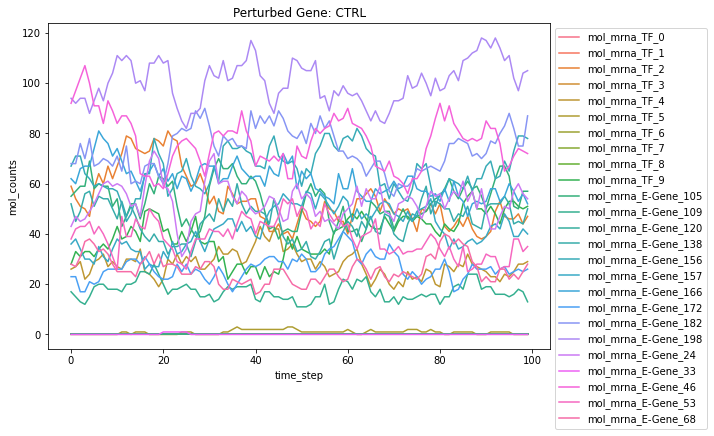

  4%|▍         | 1/26 [00:00<00:13,  1.86it/s]

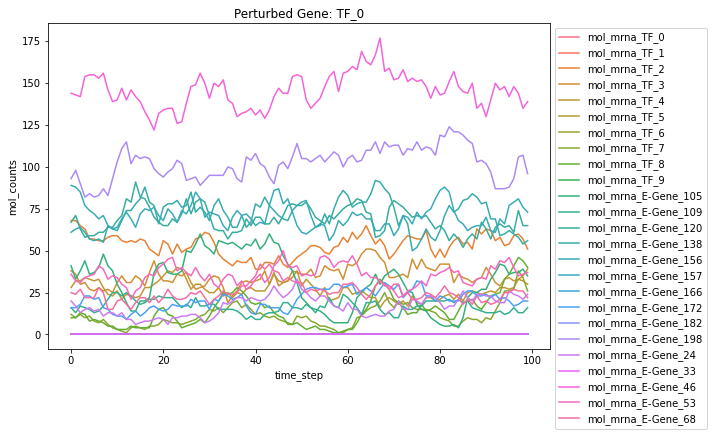

  8%|▊         | 2/26 [00:00<00:10,  2.21it/s]

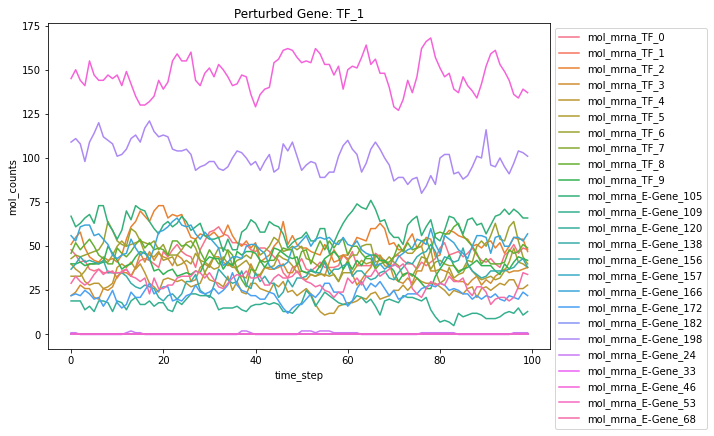

 12%|█▏        | 3/26 [00:01<00:09,  2.34it/s]

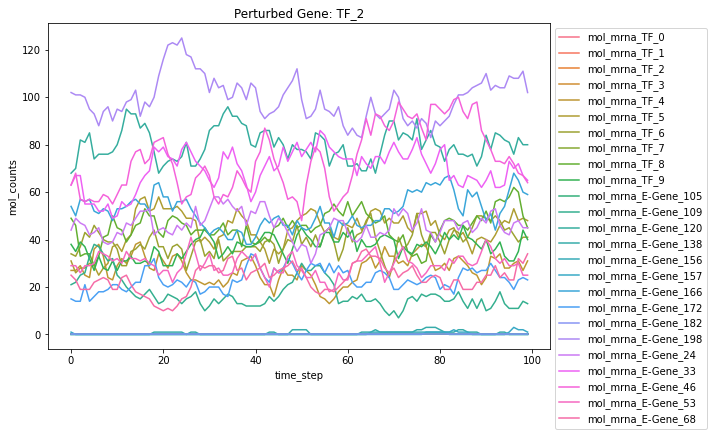

 15%|█▌        | 4/26 [00:01<00:09,  2.41it/s]

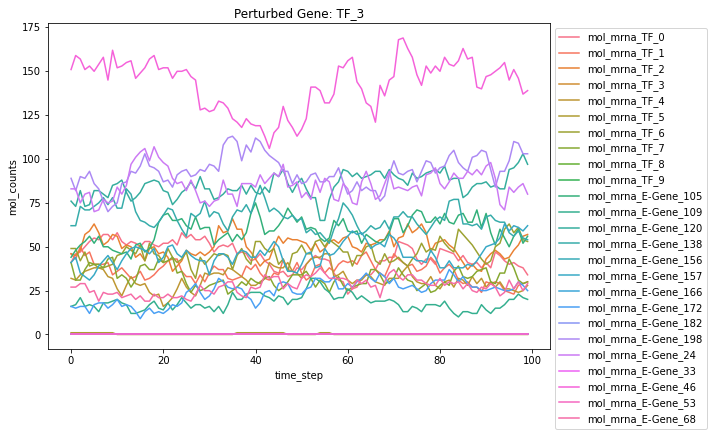

 19%|█▉        | 5/26 [00:02<00:10,  2.04it/s]

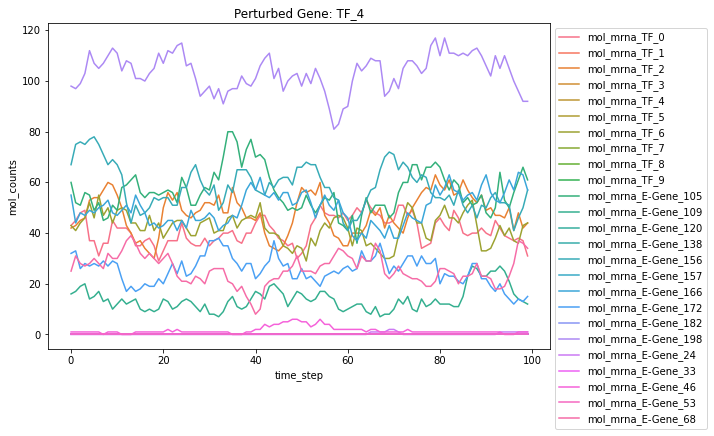

 23%|██▎       | 6/26 [00:02<00:09,  2.19it/s]

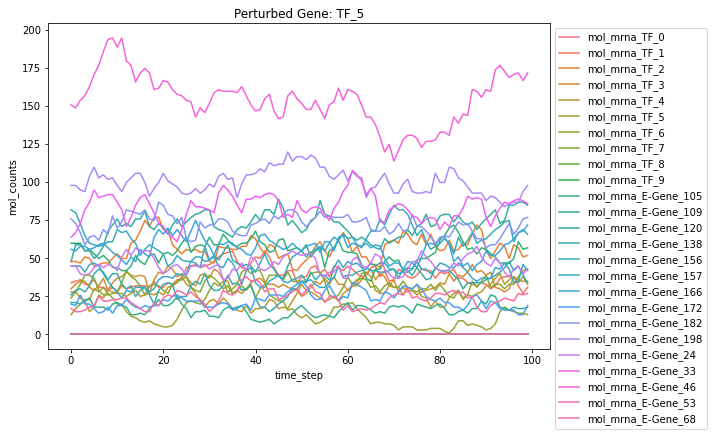

 27%|██▋       | 7/26 [00:03<00:08,  2.29it/s]

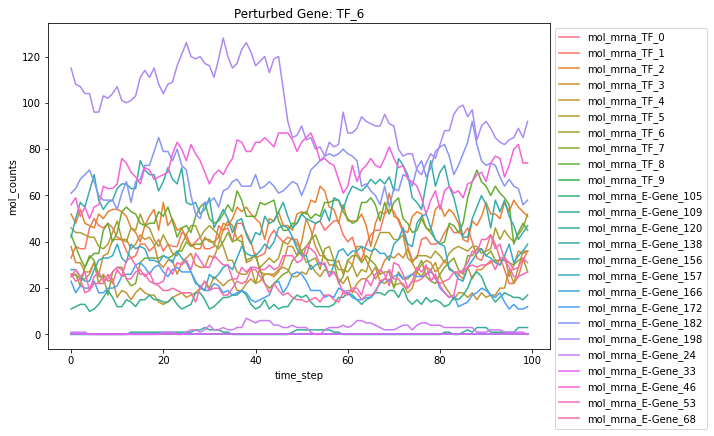

 31%|███       | 8/26 [00:03<00:07,  2.37it/s]

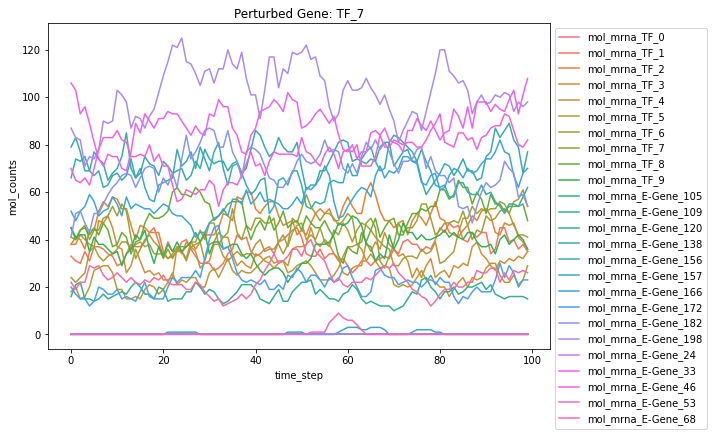

 35%|███▍      | 9/26 [00:03<00:07,  2.42it/s]

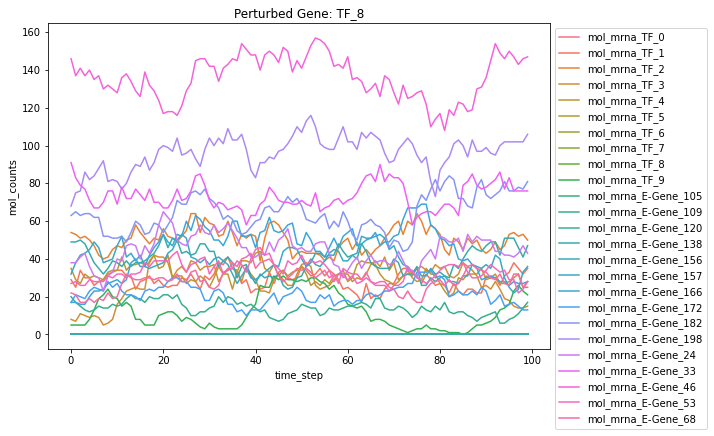

 38%|███▊      | 10/26 [00:04<00:06,  2.44it/s]

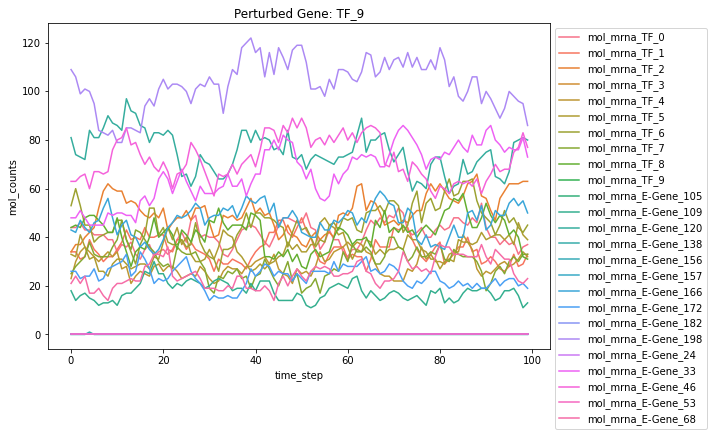

 42%|████▏     | 11/26 [00:04<00:06,  2.44it/s]

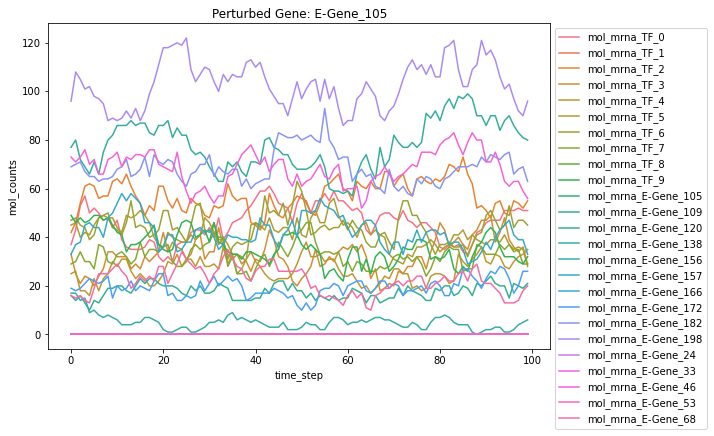

 46%|████▌     | 12/26 [00:05<00:05,  2.47it/s]

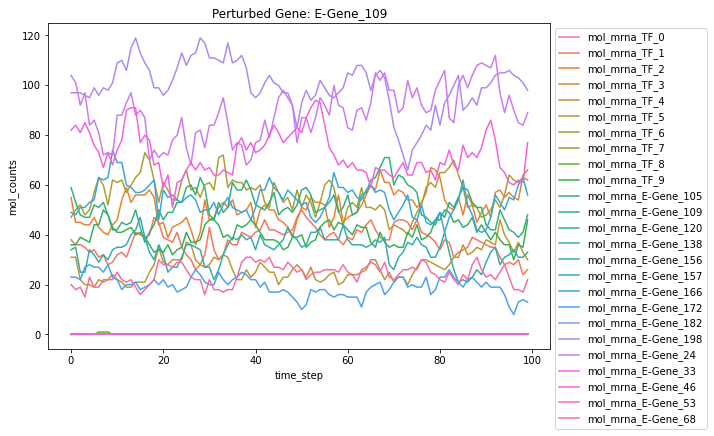

 50%|█████     | 13/26 [00:05<00:05,  2.48it/s]

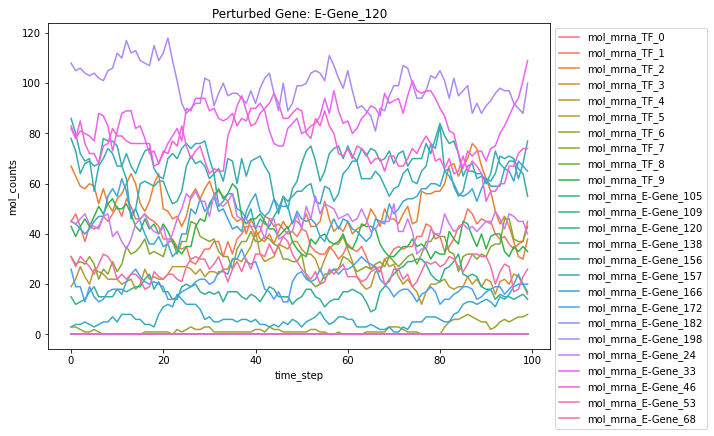

 54%|█████▍    | 14/26 [00:05<00:04,  2.51it/s]

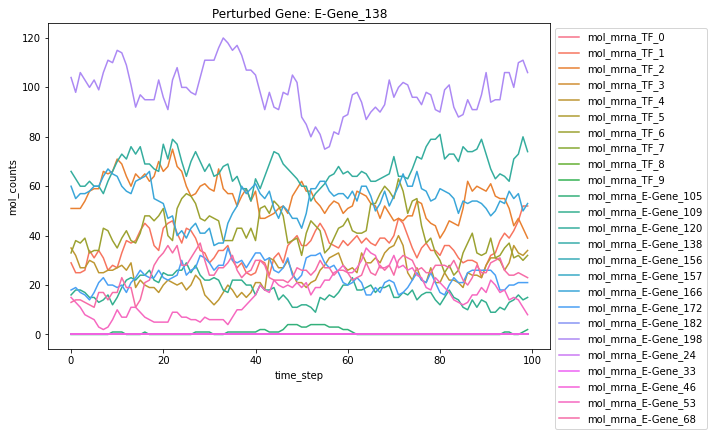

 58%|█████▊    | 15/26 [00:06<00:05,  1.98it/s]

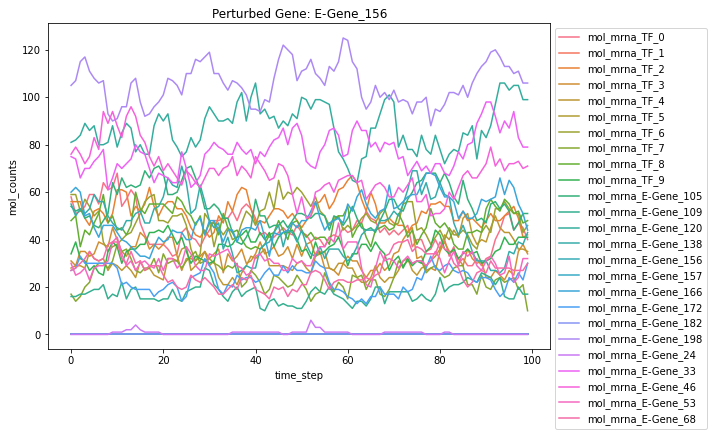

 62%|██████▏   | 16/26 [00:07<00:04,  2.12it/s]

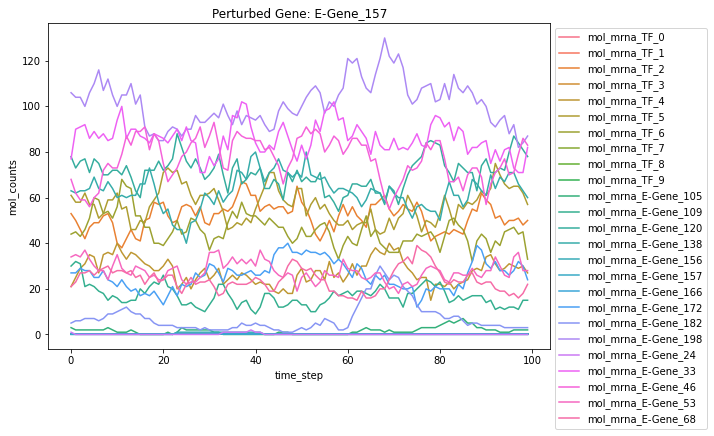

 65%|██████▌   | 17/26 [00:07<00:04,  2.24it/s]

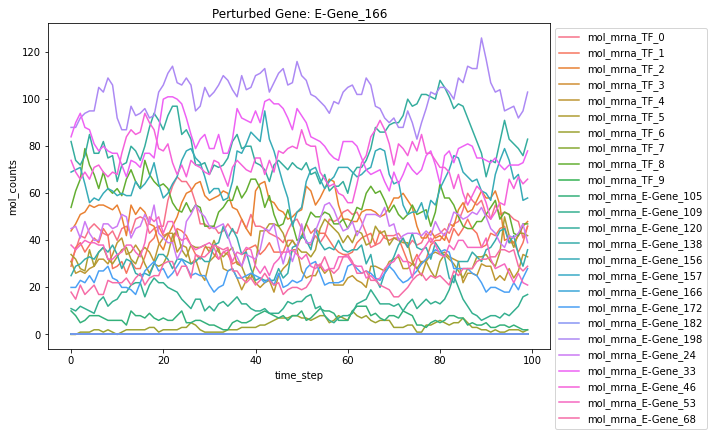

 69%|██████▉   | 18/26 [00:07<00:03,  2.32it/s]

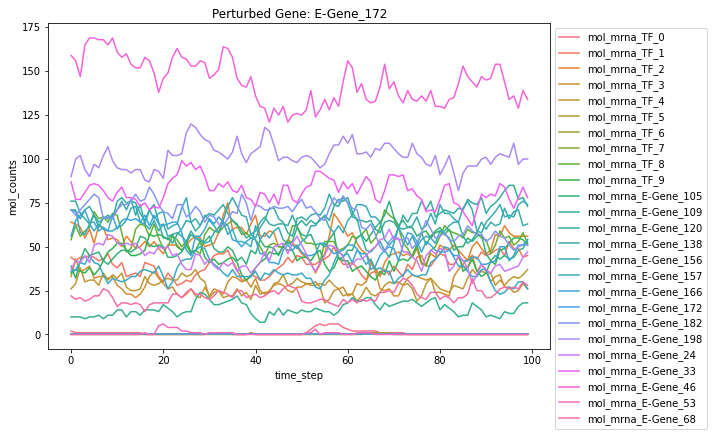

 73%|███████▎  | 19/26 [00:08<00:02,  2.39it/s]

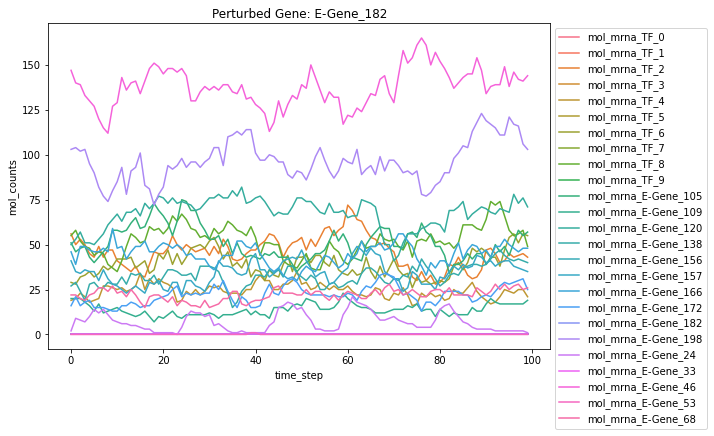

 77%|███████▋  | 20/26 [00:08<00:02,  2.41it/s]

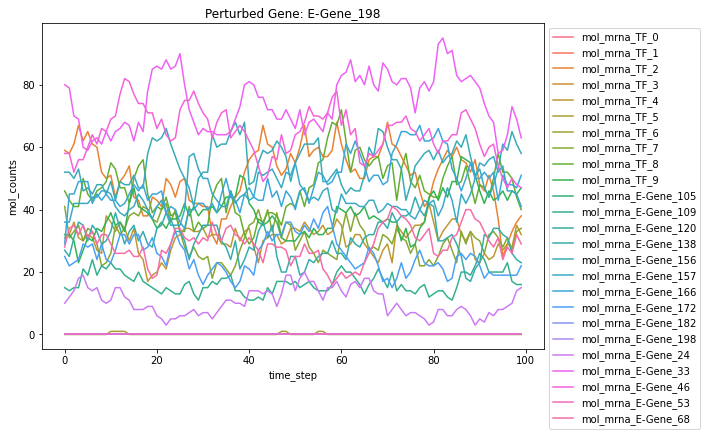

 81%|████████  | 21/26 [00:09<00:02,  2.47it/s]

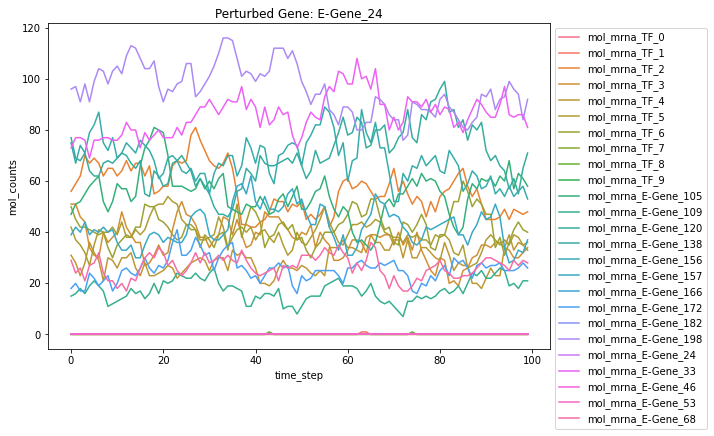

 85%|████████▍ | 22/26 [00:09<00:01,  2.45it/s]

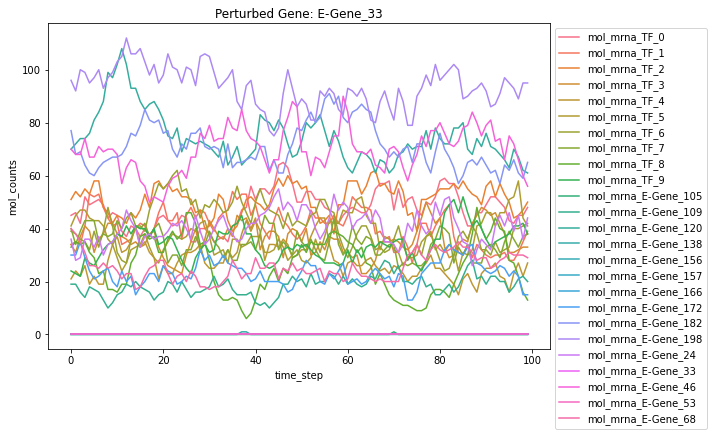

 88%|████████▊ | 23/26 [00:09<00:01,  2.48it/s]

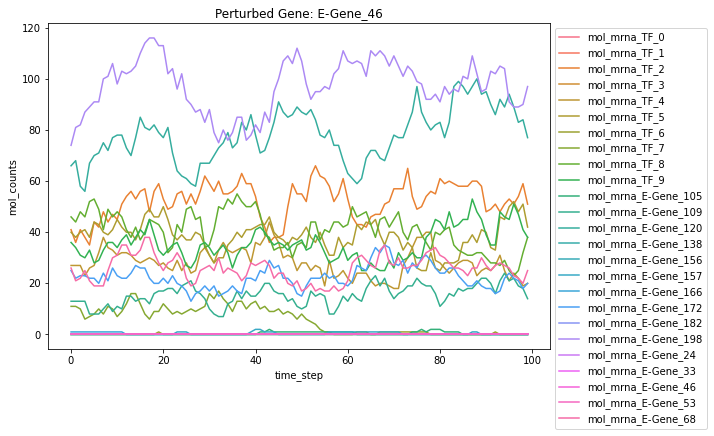

 92%|█████████▏| 24/26 [00:10<00:00,  2.52it/s]

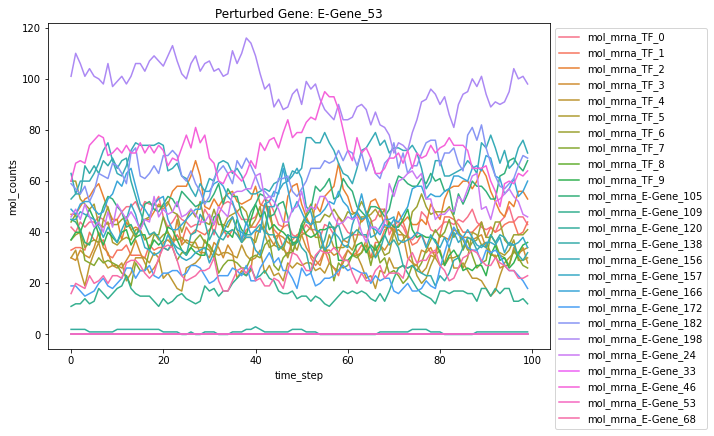

 96%|█████████▌| 25/26 [00:10<00:00,  2.53it/s]

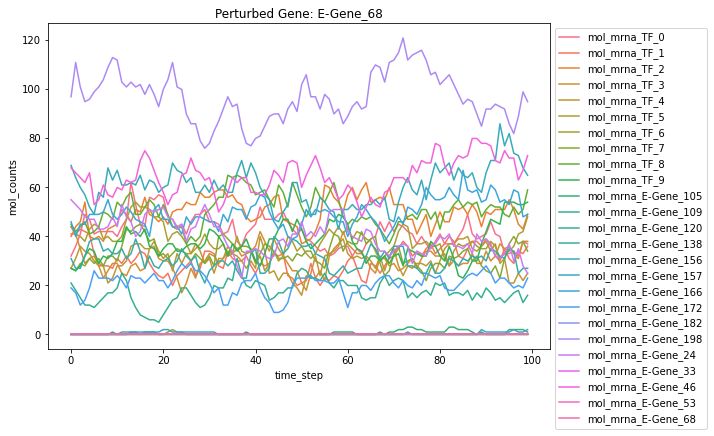

100%|██████████| 26/26 [00:11<00:00,  2.30it/s]


In [30]:
for gene in tqdm(df.perturbed_gene.unique()):
    gene_df = df.loc[df.perturbed_gene == gene]
    
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=gene_df, x='time_step', y='mol_counts', hue='mol')
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.title(f'Perturbed Gene: {gene}')
    plt.show()

In [29]:
for gene in tqdm(df.perturbed_gene.unique()):
    
    if gene == athena.ctrl_label:
        continue
    
    mol = 'mol_mrna_' + gene
    gene_df = df.loc[df.perturbed_gene == gene]
    mol_counts = gene_df.loc[gene_df.mol == mol, 'mol_counts'].unique()
    
    print (f"Perturbed Gene: {gene} Unique Counts: {mol_counts}")

100%|██████████| 26/26 [00:00<00:00, 200.48it/s]

Perturbed Gene: TF_0 Unique Counts: [0.]
Perturbed Gene: TF_1 Unique Counts: [0.]
Perturbed Gene: TF_2 Unique Counts: [0.]
Perturbed Gene: TF_3 Unique Counts: [0.]
Perturbed Gene: TF_4 Unique Counts: [0.]
Perturbed Gene: TF_5 Unique Counts: [0.]
Perturbed Gene: TF_6 Unique Counts: [0.]
Perturbed Gene: TF_7 Unique Counts: [0.]
Perturbed Gene: TF_8 Unique Counts: [0.]
Perturbed Gene: TF_9 Unique Counts: [0.]
Perturbed Gene: E-Gene_105 Unique Counts: [0.]
Perturbed Gene: E-Gene_109 Unique Counts: [0.]
Perturbed Gene: E-Gene_120 Unique Counts: [0.]
Perturbed Gene: E-Gene_138 Unique Counts: [0.]
Perturbed Gene: E-Gene_156 Unique Counts: [0.]
Perturbed Gene: E-Gene_157 Unique Counts: [0.]
Perturbed Gene: E-Gene_166 Unique Counts: [0.]
Perturbed Gene: E-Gene_172 Unique Counts: [0.]
Perturbed Gene: E-Gene_182 Unique Counts: [0.]
Perturbed Gene: E-Gene_198 Unique Counts: [0.]
Perturbed Gene: E-Gene_24 Unique Counts: [0.]
Perturbed Gene: E-Gene_33 Unique Counts: [0.]
Perturbed Gene: E-Gene_46 Un